In [1]:
# Imports

########################################################################
# Python Standard Libraries
import os
import multiprocessing
from timeit import default_timer as timer
import random
import math

########################################################################
# Numpy Library
import numpy as np # linear algebra

########################################################################
# Pandas Library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

########################################################################
# MATPLOT Library
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
%matplotlib inline

########################################################################
# SKLearn Library
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc, multilabel_confusion_matrix

########################################################################
# SCIPY Library
from scipy.stats import gaussian_kde
import scipy.stats as st


########################################################################
# Keras Library
import keras
from keras.models import Sequential
from keras.layers import Dense

########################################################################
# Init random seed
#seed = 13
#np.random.seed(seed)

In [2]:
# Utility functions
########################################################################
# Print system information
def print_system_info():
    mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')  # e.g. 4015976448
    mem_gib = mem_bytes/(1024.**3)  # e.g. 3.74
    print("{:<23}{:f} GB".format('RAM:', mem_gib))
    print("{:<23}{:d}".format('CORES:', multiprocessing.cpu_count()))
    !lscpu

########################################################################
# Walk through input files
def print_input_files():
    # Input data files are available in the "../input/" directory.
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

########################################################################
# Dump text files
def dump_text_file(fname):
    with open(fname, 'r') as f:
        print(f.read())

########################################################################
# Dump CSV files
def dump_csv_file(fname, count=5):
    # count: 0 - column names only, -1 - all rows, default = 5 rows max
    df = pd.read_csv(fname)
    if count < 0:
        count = df.shape[0]
    return df.head(count)

########################################################################
# Dataset related functions
ds_nbaiot = '/kaggle/input/nbaiot-dataset'
dn_nbaiot = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell', 'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera', 'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam', 'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']

def fname(ds, f):
    if '.csv' not in f:
        f = f'{f}.csv'
    return os.path.join(ds, f)

def fname_nbaiot(f):
    return fname(ds_nbaiot, f)

def get_nbaiot_device_files():
    nbaiot_all_files = dump_csv_file(fname_nbaiot('data_summary'), -1)
    nbaiot_all_files = nbaiot_all_files.iloc[:,0:1].values
    device_id = 1
    indices = []
    for j in range(len(nbaiot_all_files)):
        if str(device_id) not in str(nbaiot_all_files[j]):
            indices.append(j)
            device_id += 1
    nbaiot_device_files = np.split(nbaiot_all_files, indices)
    return nbaiot_device_files

def get_nbaiot_device_data(device_id, count_norm=-1, count_anom=-1):
    if device_id < 1 or device_id > 9:
        assert False, "Please provide a valid device ID 1-9, both inclusive"
    if count_anom == -1:
        count_anom = count_norm
    device_index = device_id -1
    device_files = get_nbaiot_device_files()
    device_file = device_files[device_index]
    df = pd.DataFrame()
    y = []
    for i in range(len(device_file)):
        fname = str(device_file[i][0])
        df_c = pd.read_csv(fname_nbaiot(fname))
        count = count_anom
        if 'benign' in fname:
            count = count_norm
        rows = count if count >=0 else df_c.shape[0]
        print("processing", fname, "rows =", rows)
        y_np = np.ones(rows) if 'benign' in fname else np.zeros(rows)
        y.extend(y_np.tolist())
        df = pd.concat([df.iloc[:,:].reset_index(drop=True),
                      df_c.iloc[:rows,:].reset_index(drop=True)], axis=0)
    X = df.iloc[:,:].values
    y = np.array(y)
    Xdf = df
    return (X, y, Xdf)

def get_nbaiot_devices_data():
    devices_data = []
    for i in range(9):
        device_id = i + 1
        (X, y) = get_nbaiot_device_data(device_id)
        devices_data.append((X, y))
    return devices_data
#print_input_files()
print_system_info()

RAM:                   15.642132 GB
CORES:                 2
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.184
BogoMIPS:            4000.36
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave av

In [3]:
def remove_correlated_features(df, threshold):
    df = df.copy()
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find features with correlation greater than a threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop features 
    df.drop(to_drop, axis=1, inplace=True)
    return df.iloc[:,:].values

def mark_important_features(vector, pc_keep): # pc_keep is the percentage (0-100) of labels to keep
    th = np.percentile(vector,(100-pc_keep)) # threshold, calculate percentile (100 - percentage) from percentage
    important_bool = (vector >= th)
    important_int = important_bool.astype(int)
    return important_int

def select_features(X, X_norm, X_anom, threshold):
    rows_n = X_norm.shape[0]
    rows_a = X_anom.shape[0]
    if rows_n == 0 or rows_a == 0:
        return X

    y_norm = np.ones(rows_n)
    y_anom = -1 * np.ones(rows_a)

    reg_n = LinearRegression(fit_intercept=False)
    reg_n.fit(X_norm, y_norm)
    coef_n = abs(reg_n.coef_)
    n = mark_important_features(coef_n, threshold)

    reg_a = LinearRegression(fit_intercept=False)
    reg_a.fit(X_anom, y_anom)
    coef_a = abs(reg_a.coef_)
    a = mark_important_features(coef_a, threshold)
   
    mask = np.bitwise_or(n,a)
    mask = mask == 1 # convert to Boolean
    X_sel = X[:, mask]
    return X_sel

In [4]:
 def place_optimal(a):
    if len(a) == 0:
        return []
    if len(a) == 1:
        return [a[0]]
    if len(a) == 2:
        return [a[-1], a[0]]

    x = [a[-1], a[0]]
    y = place_optimal(a[1:-1])
    y.reverse()
    x.extend(y)
    return x

def place_layers(a):
    a.sort()
    return place_optimal(a)

In [5]:
def compute_changes(x, y):
    assert x.ndim == 1 and y.ndim == 1, 'Expecting 1 dimension array, received x: {} and y: {}'.format(x.ndim, y.ndim)
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    xy = np.column_stack((x,y))
    xy = xy[np.argsort(xy[:, 0])] # sort by x
    changes = 0
    prev_y = None
    for i in range(1, xy.shape[0]):
        y = xy[i][1]
        if y != prev_y:
            prev_y = y
            changes += 1
    return changes

def create_network_structure_dahlia(X, y):
    changes = []
    for i in range(X.shape[1]):
        x = X[:,i]
        change = compute_changes(x,y)
        changes.append(change)
    structure = list(set(changes))
    structure = list(set(np.ceil(np.log(structure))))
    N = X.shape[0]
    structure = [np.floor(math.sqrt(N/2)/s) for s in structure]
    structure = place_layers(structure)
    return structure

def create_network_structure_heuristics(X, y):
    structure = []
    N = X.shape[0]
    m = 1
    node_count_layer_1 = int(math.sqrt((m + 2) * N) + 2 * math.sqrt(N / (m + 2)))
    node_count_layer_2 = int(m * math.sqrt(N / (m + 2)))
    structure.append(node_count_layer_1)
    structure.append(node_count_layer_2)
    return structure

def create_network_structure_genetic(X, y):
    structure = []
    l = 18
    K = 11
    chromosome = ''
    for i in range(l):
        x = random.randint(0, 1)
        chromosome += '{}'.format(x)
    chromosome_left = chromosome[0:K]
    chromosome_right = chromosome[K:]
    #print('chromosome: {}'.format(chromosome))
    #print('split: {} {}'.format(chromosome_left, chromosome_right))
    #print('chromosome_left: {}'.format(chromosome_left))
    #print('chromosome_right: {}'.format(chromosome_right))
    node_count_layer_1 = int(chromosome_left, 2) + random.randint(1, 10)
    node_count_layer_2 = int(chromosome_right, 2) + random.randint(1, 10)
    structure.append(node_count_layer_1)
    structure.append(node_count_layer_2)
    return structure

def create_network_structure_random(X, y):
    layer_count_min = 15
    layer_count_max = 25
    node_count_min = 10
    node_count_max = 97
    
    structure = []
    layer_count = random.randint(layer_count_min, layer_count_max)
    for i in range(layer_count):
        node_count = random.randint(node_count_min, node_count_max)
        structure.append(node_count)
    return structure

In [6]:
def create_binary_classifier(hidden_layers, input_dim):
    layers = []
    for hl in hidden_layers:
        if hl > 0:
            layers.append(hl)

    layer_count = len(layers)
    assert layer_count >= 1, 'at least 1 non-zero hidden layer is needed'
    np.random.seed(42)
    model = Sequential()
    model.add(Dense(layers[0],input_dim=input_dim,activation='relu'))
    for i in range(1, layer_count):
        model.add(Dense(layers[i],activation='relu'))

    model.add(Dense(1,activation='sigmoid'))
    #model.summary()
    adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(loss = 'binary_crossentropy',
             optimizer =adam,metrics=['accuracy'])
    return model

In [7]:
def compute_time_complexity_single_pass(neurons_input, structure, neurons_output):
    count_hidden_layers = len(structure)
    neurons = [neurons_input, *structure, neurons_output]
    complexity = 0
    for i in range(count_hidden_layers + 1):
        complexity += neurons[i] * neurons[i+1]
    return complexity

In [8]:
model = None
prev_wbs = []
diff_wbs = []
class WeightMonitor(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        i = 1
        for layer in model.layers:
            (w, b) = layer.get_weights()
            prev_wbs.append([w,b])
            b = b.shape
            w = w.shape
            #print(f"layer{i} weights = {w}, biases = {b}")
            i += 1
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        if True:
            w_d = 0
            b_d = 0
            layer_count = len(model.layers)
            for i in range(layer_count):
                (w_c, b_c) = model.layers[i].get_weights() # current weigths and biases
                (w_p, b_p) = prev_wbs[i] # previous weigths and biases
                w_d += np.absolute(w_c - w_p).mean()
                b_d += np.absolute(b_c - b_p).mean()
                prev_wbs[i] = (w_c, b_c) # update old weigths and biases
            w_d = w_d / layer_count
            b_d = b_d / layer_count
            diff_wbs.append((w_d, b_d))
            print(f'{epoch},{w_d},{b_d}')

def plot_weight_diff(title, diff_wbs):
    list_w_d = []
    list_b_d = []
    for wbs in diff_wbs:
        (w_d, b_d) = wbs
        list_w_d.append(w_d)
        list_b_d.append(b_d)
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(list_w_d)
    plt.xlabel('epoch')
    plt.ylabel('weight diff')
    plt.subplot(122)
    plt.plot(list_b_d)
    plt.xlabel('epoch')
    plt.ylabel('bias diff')
    plt.suptitle(f'{title}\nAverage changes in weights and biases vs the number of epochs')
    plt.show()

In [9]:
def compute_report(title, model, X, y):
    y_pred = model.predict(X)
    y_pred[y_pred <= 0] = -1 # convert negative values as 0 for anomaly
    y_pred[y_pred > 0] = 1 # convert positive values as 1 for normal
    acc = accuracy_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
    cr = classification_report(y, y_pred)
    print("title,acc,tn,fp,fn,tp")
    print(f'{title}-cm,{acc:.2f},{tn},{fp},{fn},{tp}')
    #print(f'{cr}')
    results = model.evaluate(X, y, verbose=0)
    print(f'{title}-eval,{results}')

def evaluate_different_structures(title, X, y):
    y[y <= 0] = -1 # map negative and 0 as anomaly (-1)
    y[y > 0] = 1 # map positive numbers as normal (1)
    algorithms = [
        {'name': 'Dahlia', 'fx': create_network_structure_dahlia},
        #{'name': 'Heuristics', 'fx': create_network_structure_heuristics},
        #{'name': 'Genetic', 'fx': create_network_structure_genetic},
        #{'name': 'Random', 'fx': create_network_structure_random},
    ]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    print (f"========{title}========")
    feature_count = X.shape[1]
    print(f'Features={feature_count}')
    for algo in algorithms:
        global model
        global prev_wbs
        global diff_wbs
        prev_wbs = []
        diff_wbs = []
        print(f"********{algo['name']}********")
        structure = algo['fx'](X_train,y_train)
        print(f'NN Structure: layers={len(structure)}, neurons: {structure}')
        print('complexity: ', compute_time_complexity_single_pass(feature_count, structure, 1))
        model = create_binary_classifier(structure, feature_count)
        print('epoch,avg_weight_diff,avg_bias_diff')
        model.fit(X_train,y_train,epochs=150,batch_size=10,verbose=0, callbacks=[WeightMonitor()])
        compute_report('training', model, X_train, y_train)
        compute_report('validation', model, X_test, y_test)
        plot_weight_diff(title,diff_wbs)

In [10]:
debug_flag = True

processing 1.benign.csv rows = 1000
processing 1.gafgyt.combo.csv rows = 100
processing 1.gafgyt.junk.csv rows = 100
processing 1.gafgyt.scan.csv rows = 100
processing 1.gafgyt.tcp.csv rows = 100
processing 1.gafgyt.udp.csv rows = 100
processing 1.mirai.ack.csv rows = 100
processing 1.mirai.scan.csv rows = 100
processing 1.mirai.syn.csv rows = 100
processing 1.mirai.udp.csv rows = 100
processing 1.mirai.udpplain.csv rows = 100
========Danmini_Doorbell========
Features=43
********Dahlia********
NN Structure: layers=5, neurons: [8.0, 3.0, 5.0, 4.0, 6.0]
complexity:  433.0
epoch,avg_weight_diff,avg_bias_diff
0,0.0043713315001999336,0.007455674310525258
1,0.004826941100570063,0.008069391439979276
2,0.006006218842230737,0.008908875247774025
3,0.007050195708870888,0.009403536523071429
4,0.007109205975818138,0.00891672819852829
5,0.007283005320156614,0.00847839416625599
6,0.007236771207923691,0.008412625019749006
7,0.007565402192994952,0.008204608379552761
8,0.008745566165695587,0.00972624394

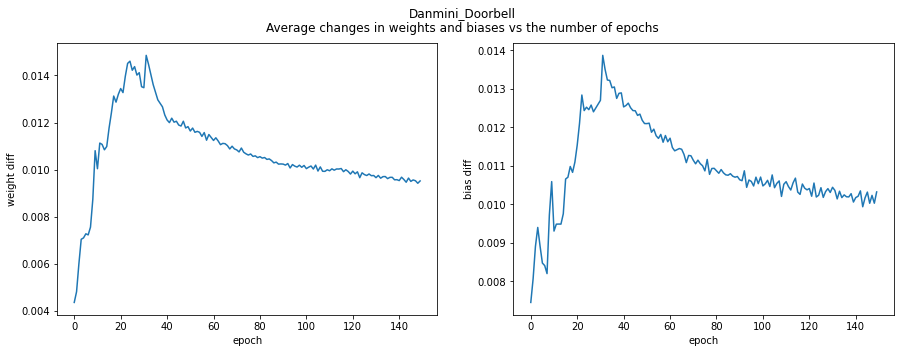

processing 2.benign.csv rows = 1000
processing 2.gafgyt.combo.csv rows = 100
processing 2.gafgyt.junk.csv rows = 100
processing 2.gafgyt.scan.csv rows = 100
processing 2.gafgyt.tcp.csv rows = 100
processing 2.gafgyt.udp.csv rows = 100
processing 2.mirai.ack.csv rows = 100
processing 2.mirai.scan.csv rows = 100
processing 2.mirai.syn.csv rows = 100
processing 2.mirai.udp.csv rows = 100
processing 2.mirai.udpplain.csv rows = 100
========Ecobee_Thermostat========
Features=54
********Dahlia********
NN Structure: layers=4, neurons: [6.0, 3.0, 4.0, 5.0]
complexity:  379.0
epoch,avg_weight_diff,avg_bias_diff
0,0.008922093454748392,0.008937624469399452
1,0.009557029418647289,0.008133963961154223
2,0.009554758295416832,0.006717830058187246
3,0.009702845755964518,0.005896967276930809
4,0.010531461238861084,0.0059254658408463
5,0.012101356964558363,0.008176167495548725
6,0.011745873745530844,0.007693470641970635
7,0.01192808635532856,0.008004320226609707
8,0.012042677216231822,0.00732844155281782

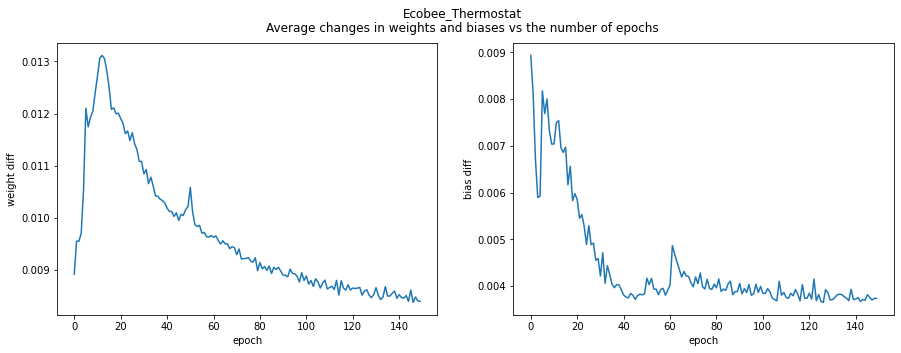

processing 3.benign.csv rows = 1000
processing 3.gafgyt.combo.csv rows = 100
processing 3.gafgyt.junk.csv rows = 100
processing 3.gafgyt.scan.csv rows = 100
processing 3.gafgyt.tcp.csv rows = 100
processing 3.gafgyt.udp.csv rows = 100
========Ennio_Doorbell========
Features=53
********Dahlia********
NN Structure: layers=5, neurons: [7.0, 3.0, 4.0, 3.0, 5.0]
complexity:  436.0
epoch,avg_weight_diff,avg_bias_diff
0,0.0032018431229516864,0.003772656937750677
1,0.003340328151049713,0.004126651018547515
2,0.0030600602234092853,0.003562664419102172
3,0.0032834773883223534,0.002429619761339078
4,0.003520085185300559,0.003374026525610437
5,0.004018827807158232,0.0029863552238869793
6,0.004703156067989767,0.003579887757950928
7,0.005638162062192957,0.003727459472429473
8,0.0061055463350688415,0.003941440120494614
9,0.0062783906469121575,0.003748958342233285
10,0.006505364164089163,0.003920362906986459
11,0.006708238584299882,0.004090697514281298
12,0.006576171998555462,0.004142182485035543
13,0

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


training-eval,[-0.346160352230072, 0.6736318469047546]
title,acc,tn,fp,fn,tp
validation-cm,0.65,0,0,0,321
validation-eval,[-0.22645016014575958, 0.6484848260879517]


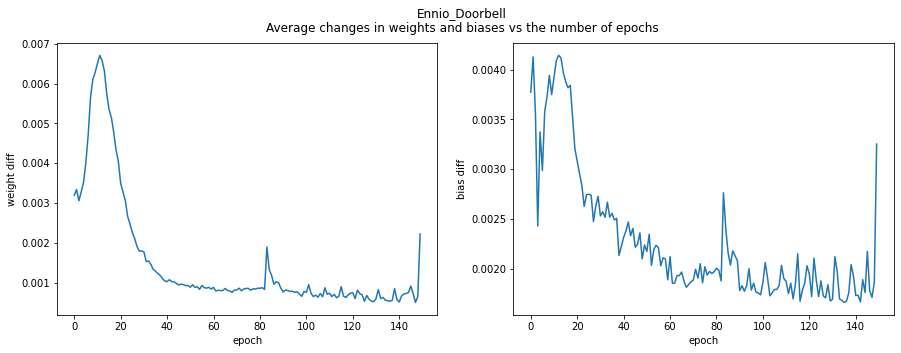

processing 4.benign.csv rows = 1000
processing 4.gafgyt.combo.csv rows = 100
processing 4.gafgyt.junk.csv rows = 100
processing 4.gafgyt.scan.csv rows = 100
processing 4.gafgyt.tcp.csv rows = 100
processing 4.gafgyt.udp.csv rows = 100
processing 4.mirai.ack.csv rows = 100
processing 4.mirai.scan.csv rows = 100
processing 4.mirai.syn.csv rows = 100
processing 4.mirai.udp.csv rows = 100
processing 4.mirai.udpplain.csv rows = 100
========Philips_B120N10_Baby_Monitor========
Features=54
********Dahlia********
NN Structure: layers=3, neurons: [6.0, 4.0, 5.0]
complexity:  373.0
epoch,avg_weight_diff,avg_bias_diff
0,0.0062931496649980545,0.007827503373846412
1,0.005478492588736117,0.006635530851781368
2,0.005964039941318333,0.007056442118482664
3,0.0063236316200345755,0.007808990994817577
4,0.006006626761518419,0.007434109153109603
5,0.005289386608637869,0.006950993905775249
6,0.004635384073480964,0.006378963982569985
7,0.004002265341114253,0.005962522322079167
8,0.003666754113510251,0.005674

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


training-eval,[-0.8577324151992798, 0.49776118993759155]
title,acc,tn,fp,fn,tp
validation-cm,0.49,0,0,0,325
validation-eval,[-0.8805385828018188, 0.48787879943847656]


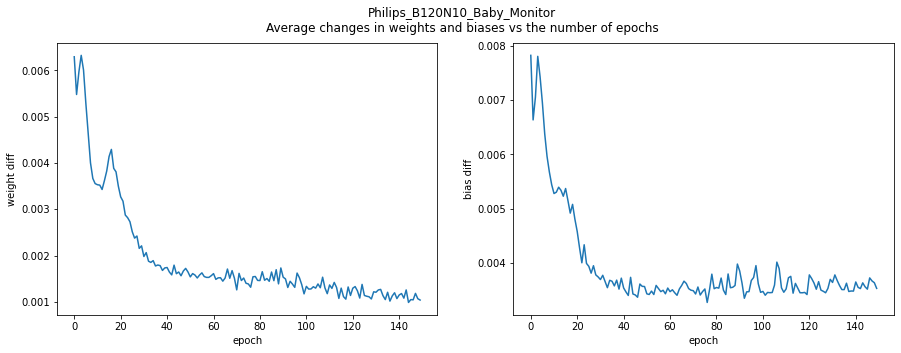

processing 5.benign.csv rows = 1000
processing 5.gafgyt.combo.csv rows = 100
processing 5.gafgyt.junk.csv rows = 100
processing 5.gafgyt.scan.csv rows = 100
processing 5.gafgyt.tcp.csv rows = 100
processing 5.gafgyt.udp.csv rows = 100
processing 5.mirai.ack.csv rows = 100
processing 5.mirai.scan.csv rows = 100
processing 5.mirai.syn.csv rows = 100
processing 5.mirai.udp.csv rows = 100
processing 5.mirai.udpplain.csv rows = 100
========Provision_PT_737E_Security_Camera========
Features=36
********Dahlia********
NN Structure: layers=3, neurons: [5.0, 3.0, 4.0]
complexity:  211.0
epoch,avg_weight_diff,avg_bias_diff
0,0.0069277782458812,0.008610361022874713
1,0.007261993363499641,0.009414243744686246
2,0.00920980388764292,0.008707678527571261
3,0.009919325006194413,0.007521431369241327
4,0.009678589412942529,0.008547672594431788
5,0.009353348752483726,0.008082024229224771
6,0.008914066478610039,0.007723880000412464
7,0.009107805322855711,0.008511823951266706
8,0.009659167961217463,0.009755

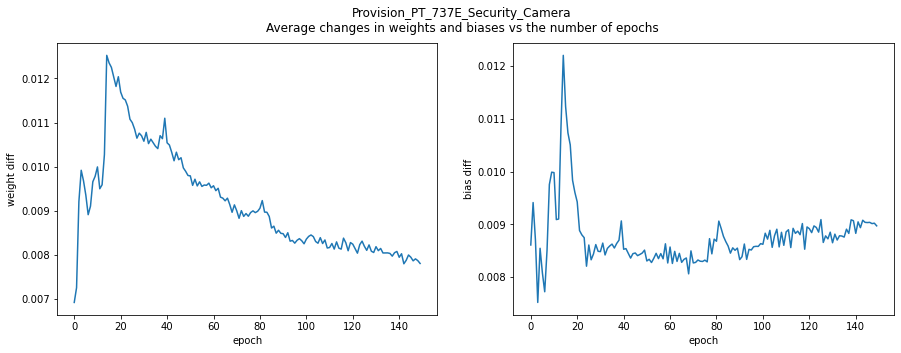

processing 6.benign.csv rows = 1000
processing 6.gafgyt.combo.csv rows = 100
processing 6.gafgyt.junk.csv rows = 100
processing 6.gafgyt.scan.csv rows = 100
processing 6.gafgyt.tcp.csv rows = 100
processing 6.gafgyt.udp.csv rows = 100
processing 6.mirai.ack.csv rows = 100
processing 6.mirai.scan.csv rows = 100
processing 6.mirai.syn.csv rows = 100
processing 6.mirai.udp.csv rows = 100
processing 6.mirai.udpplain.csv rows = 100
========Provision_PT_838_Security_Camera========
Features=42
********Dahlia********
NN Structure: layers=4, neurons: [6.0, 3.0, 4.0, 5.0]
complexity:  307.0
epoch,avg_weight_diff,avg_bias_diff
0,0.00679661724716425,0.008872383926063775
1,0.005407352559268474,0.008349188975989819
2,0.005500890826806426,0.00809612860903144
3,0.004014302976429462,0.006564405560493469
4,0.0022210602182894945,0.004157306253910064
5,0.0027833363972604276,0.0045079644303768875
6,0.002771994657814503,0.004631089093163609
7,0.002844031294807792,0.004640811076387763
8,0.0029210986103862524

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


title,acc,tn,fp,fn,tp
training-cm,0.50,0,0,0,675
training-eval,[-0.835547685623169, 0.4910447895526886]
title,acc,tn,fp,fn,tp
validation-cm,0.49,0,0,0,325
validation-eval,[-0.8689764142036438, 0.489393949508667]


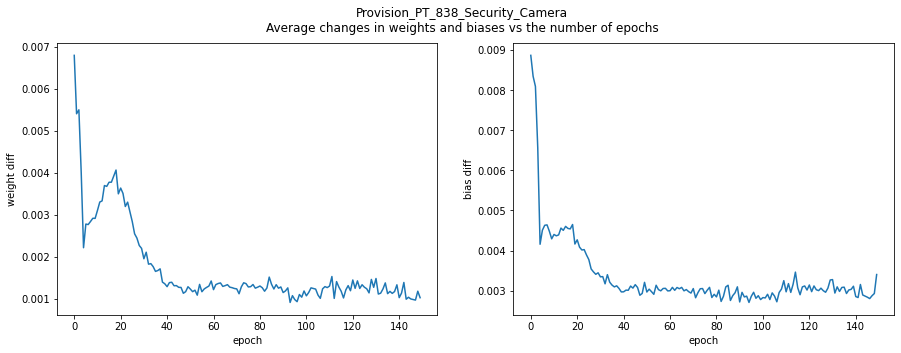

processing 7.benign.csv rows = 1000
processing 7.gafgyt.combo.csv rows = 100
processing 7.gafgyt.junk.csv rows = 100
processing 7.gafgyt.scan.csv rows = 100
processing 7.gafgyt.tcp.csv rows = 100
processing 7.gafgyt.udp.csv rows = 100
========Samsung_SNH_1011_N_Webcam========
Features=48
********Dahlia********
NN Structure: layers=5, neurons: [7.0, 3.0, 4.0, 3.0, 5.0]
complexity:  401.0
epoch,avg_weight_diff,avg_bias_diff
0,0.003285268224620571,0.0025426614932560674
1,0.002416485183251401,0.0023990096766889715
2,0.002263105328893289,0.0024311176918369406
3,0.0035120737350856266,0.0026020709531925
4,0.004127134239145865,0.0027589496991519504
5,0.00449794193264097,0.002954407944343984
6,0.004703478965287407,0.003061724524134964
7,0.004850721141944329,0.0031196127814231054
8,0.004723164835013449,0.0030438395454742326
9,0.004837686972071727,0.002942974420269214
10,0.004866565577685833,0.0030478183180093765
11,0.005061468458734453,0.003037465469484838
12,0.005128548907426496,0.0030564046410

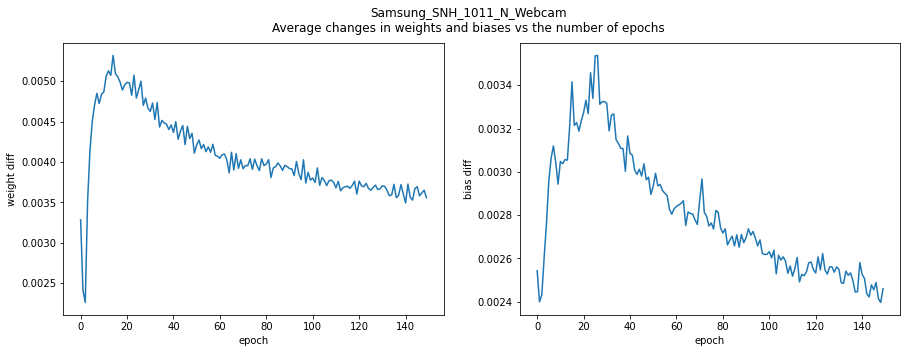

processing 8.benign.csv rows = 1000
processing 8.gafgyt.combo.csv rows = 100
processing 8.gafgyt.junk.csv rows = 100
processing 8.gafgyt.scan.csv rows = 100
processing 8.gafgyt.tcp.csv rows = 100
processing 8.gafgyt.udp.csv rows = 100
processing 8.mirai.ack.csv rows = 100
processing 8.mirai.scan.csv rows = 100
processing 8.mirai.syn.csv rows = 100
processing 8.mirai.udp.csv rows = 100
processing 8.mirai.udpplain.csv rows = 100
========SimpleHome_XCS7_1002_WHT_Security_Camera========
Features=51
********Dahlia********
NN Structure: layers=4, neurons: [6.0, 3.0, 4.0, 5.0]
complexity:  361.0
epoch,avg_weight_diff,avg_bias_diff
0,0.004401807719841599,0.0051627097418531775
1,0.006322026019915938,0.00795441884547472
2,0.007813149271532894,0.008216684684157372
3,0.007779482193291188,0.008702578675001859
4,0.00897648762911558,0.009358069393783808
5,0.009384060837328434,0.009472048934549093
6,0.009822408203035593,0.01016627699136734
7,0.00914636543020606,0.009347838815301657
8,0.009510197676718

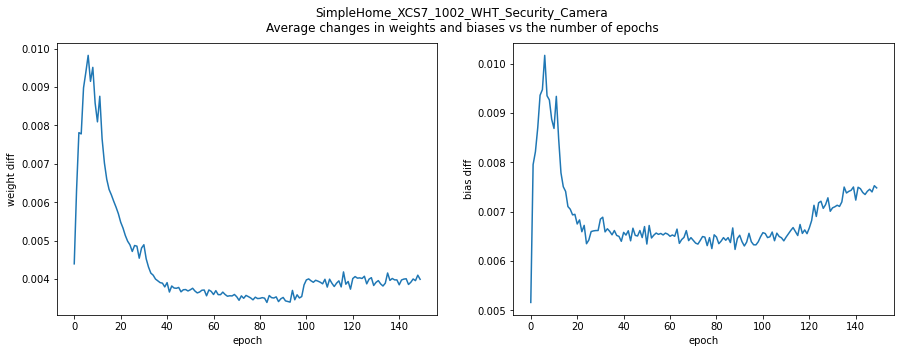

processing 9.benign.csv rows = 1000
processing 9.gafgyt.combo.csv rows = 100
processing 9.gafgyt.junk.csv rows = 100
processing 9.gafgyt.scan.csv rows = 100
processing 9.gafgyt.tcp.csv rows = 100
processing 9.gafgyt.udp.csv rows = 100
processing 9.mirai.ack.csv rows = 100
processing 9.mirai.scan.csv rows = 100
processing 9.mirai.syn.csv rows = 100
processing 9.mirai.udp.csv rows = 100
processing 9.mirai.udpplain.csv rows = 100
========SimpleHome_XCS7_1003_WHT_Security_Camera========
Features=44
********Dahlia********
NN Structure: layers=5, neurons: [8.0, 3.0, 5.0, 4.0, 6.0]
complexity:  441.0
epoch,avg_weight_diff,avg_bias_diff
0,0.0052629782585427165,0.007738244719803333
1,0.007856485705512265,0.00988848057265083
2,0.009336000541225076,0.010283564527829489
3,0.00944978006494542,0.010166344232857227
4,0.009889258770272136,0.01004733556571106
5,0.010382474244882664,0.010140871008237204
6,0.010822922534619769,0.01005575891273717
7,0.010734957953294119,0.010265775102501115
8,0.0109033863

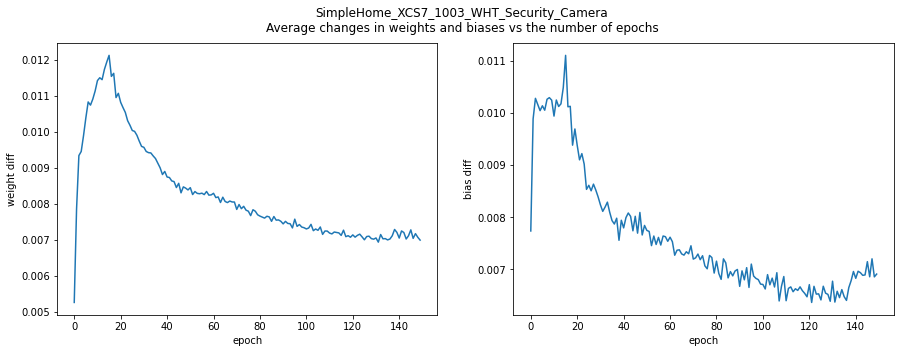

In [11]:
device_to = 9 if not debug_flag else 9
for i in range(device_to):
    device_index = i
    device_id = device_index + 1
    device_name = dn_nbaiot[device_index]
    if not debug_flag:
        (X, y, Xdf) = get_nbaiot_device_data(device_id)
    else:
        (X, y, Xdf) = get_nbaiot_device_data(device_id, 1000, 100)
    X = remove_correlated_features(Xdf, 0.98)
    X_std = StandardScaler().fit_transform(X)
    indices_norm = np.where(y >= 0.5)
    indices_anom = np.where(y <= 0.5)
    X_norm_all = X_std[indices_norm]
    X_anom_all = X_std[indices_anom]
    X_std = select_features(X_std, X_norm_all, X_anom_all,75)
    evaluate_different_structures(device_name, X_std, y)